In [1]:
import getpass
import os

from dotenv import load_dotenv

load_dotenv()

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("GROQ_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

## Create tools

In [2]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)


# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

## Create Agent Supervisor


In [12]:
from typing_extensions import TypedDict, Literal

from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["retrival", "resume"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = """
You are the Orchestrator for a job plateform, responsible for coordinating specialized agents to help users with their job search and career questions.

TEAM MEMBERS:
1. retrieval: Searches for job listings and provides market information
2. resume: Offers resume optimization and career advice

YOUR RESPONSIBILITIES:
1. Analyze the current state of the conversation
2. Classify user's intent: retrieval, resume and route to the appropriate agent
3. Ensure the user gets a complete and helpful response
4. Avoid unnecessary agent calls - only use agents when their specific skills are needed
5. Decide when the task is complete

ROUTING GUIDELINES:
- Route to Retrieval Agent when job listings or job market information is needed
- Route to Resume Agent when resume advice or career guidance is needed
- Route to FINISH when the user's request has been completely addressed

EXAMPLES OF GOOD ROUTING:

1. User asks: "I'm looking for nursing jobs in California with a BSN degree"
   - First route to Retrieval Agent to find matching nursing jobs
   - Then FINISH (resume advice not explicitly requested)

2. User asks: "I'm a financial analyst with these skills and certifications and can't get interviews"
   - First route to Retrieval Agent to find relevant financial analyst jobs
   - Then route to Resume Agent to provide tailored advice
   - Then FINISH with a complete response

"""


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["retrival", "resume", "FINISH"]


llm = ChatGroq(temperature=1, model_name="llama-3.3-70b-specdec")
# llm = ChatGroq(temperature=0, model_name="deepseek-r1-distill-llama-70b")


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal["retrival", "resume", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

## Construct Graph


In [13]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


# research_agent = create_react_agent(
#     llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math. you always be happy with first reult even if it is the same"
# )

retrival_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt="""
You are the Job Retrieval Agent, specialized in finding relevant job opportunities and market information.

YOUR RESPONSIBILITIES:
1. Search for job listings that match the user's criteria and nothing more

IMPORTANT:
- Focus on providing factual information about jobs and the job market

WHEN YOUR TASK IS COMPLETE:
- Summarize the key findings from your research

Only use the tools provided to you for research purposes.
""",
)


def retrival_node(state: State) -> Command[Literal["supervisor"]]:
    result = retrival_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="retrival")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
resume_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt="You are a coder. When finshied with execution return TASK COMPLETE",
)


def resume_node(state: State) -> Command[Literal["supervisor"]]:
    result = resume_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="resume")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("retrival", retrival_node)
builder.add_node("resume", resume_node)
graph = builder.compile()

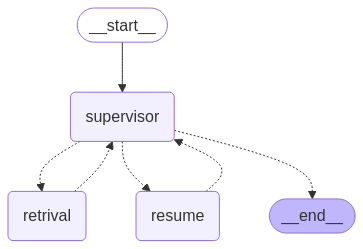

In [14]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the team


In [ ]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "I am looking for a job in software engineering in California with a bachelor's degree",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:e0c05ac2-8b29-1ffd-8530-b10e0e49d1a0',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xt9n', 'function': {'arguments': '{"query": "circumference of a circle with diameter 10"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 637, 'total_tokens': 666, 'completion_time': 0.013657476, 'prompt_time': 0.071642749, 'queue_time': 0.003990383, 'total_time': 0.085300225}, 'model_name': 'llama-3.3-70b-specdec', 'system_fingerprint': 'fp_9f325da874', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-35373ae7-a9cf-4635-95c5-e1edf30a9238-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'circumference of a circle with diameter 10'}, 'id': 'call_xt9n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 637, 'output_tokens': 29, 'total_tokens': 666})]}})
----
(('res

In [7]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:ecb43009-75be-ab5b-5b99-48e394d566f2',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6cw7', 'function': {'arguments': '{"query": "latest GDP of New York"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_6btb', 'function': {'arguments': '{"query": "latest GDP of California"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 637, 'total_tokens': 681, 'completion_time': 0.024040118, 'prompt_time': 0.06520665, 'queue_time': 0.004093221999999994, 'total_time': 0.089246768}, 'model_name': 'llama-3.3-70b-specdec', 'system_fingerprint': 'fp_985f1e4133', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-591b0556-1c19-415e-b9ec-68ab7cbb064c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'latest GDP of New York'}, 'id': 'call_6cw7', 'ty

Python REPL can execute arbitrary code. Use with caution.


(('coder:7193ba29-7437-d0f2-0a23-63d31c7426ee',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mzwj', 'function': {'arguments': '{"code": "print(($1.8 + $3.2) / 2)"}', 'name': 'python_repl_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 354, 'total_tokens': 384, 'completion_time': 0.02488603, 'prompt_time': 0.036221324, 'queue_time': 0.431368626, 'total_time': 0.061107354}, 'model_name': 'llama-3.3-70b-specdec', 'system_fingerprint': 'fp_9f325da874', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-27ae20fa-7fd4-4a05-b1c8-1e2b07c79a7f-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'print(($1.8 + $3.2) / 2)'}, 'id': 'call_mzwj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 354, 'output_tokens': 30, 'total_tokens': 384})]}})
----
(('coder:7193ba29-7437-d0f2-0a23-63d31c7426ee',), {'tools': {'messages': [ToolMessage(content="Successfully executed:\n`